In [56]:
import numpy as np
from scipy import misc
import numpy as np
import scipy.ndimage
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib as mpl 
from scipy.stats import norm
from scipy.ndimage.filters import median_filter

mpl.rcParams['figure.figsize']=(6.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=300             #72 
mpl.rcParams['figure.subplot.bottom']=.1    #.125

def rgb2gray(rgb):
    """Convert an RGB image to a gray scale one.

    Args:
        rgb: original image

    Returns:
        grayscale image
    """
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = np.round(0.2989 * r + 0.5870 * g + 0.1140 * b)
    return gray.astype(int)


def loadimg(path):
    """Load an image and convert to an NP array
    
    Args:
        path: path to the image to load
        
    Returns:
        loaded image as NP array
    """
    return np.asarray(misc.imread(path))

def watermark(shape, density):
    """Generate simple random watermark."""
    w = np.random.random(shape)-0.5
    # undersample to density
    mask = np.random.random(shape)<(1-density)
    w[mask] = 0
    mask = w < 0 
    w[mask] = -1
    mask = w > 0
    w[mask] = +1
    return w    

def non_blind_detector(x, v, w):
    """Compute rho knowing the original image."""
    wE = v-x
    rho = np.sum(wE*w)/x.size
    return rho
    

def blind_detector(v, w):
    xE = median_filter(v, size=3)
    wE = v-xE
    rho = np.sum(wE*w)/v.size
    return rho


# Watermark performance evaluation
**Martino Ferrari**

## Non-blind watermark detection

#### Exercise 1.1

For the given hypotesis:

$$
\begin{cases}
    \mathcal{H}_0:\quad v = x+z \\
    \mathcal{H}_1:\quad v = x+w+z
\end{cases}
$$

where $x$ is the host image, $w$ is the watermark and $z$ is a noise with distribution: $\mathcal{N}(0,\sigma_{noise}^2)$.    
Compute numerically the following property:

 - $P_f$
 - $P_m$
 - $P_d$
 


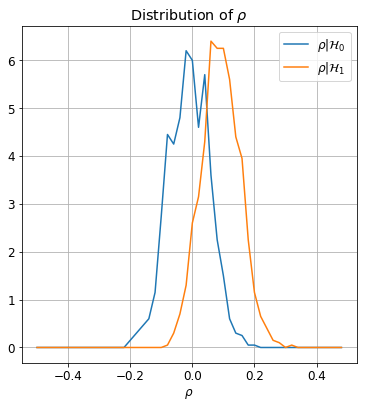

In [57]:
# load Cameraman image
x = loadimg('Cameraman.bmp')

# noise variance
var_noise = 50

# watermark intensity
gamma = 1

# watermark density 
theta = 0.1

# number of test
k = 1000

# resulting rhos
rhos_0 = np.zeros(k)
rhos_1 = np.zeros(k)

# generation of noise
z = np.random.normal(0, var_noise, x.shape)
# genration of resulting image
v = x + z
    
for i in range(0, k):
    # watermark
    w = watermark(x.shape, theta)

    rhos_0[i] = non_blind_detector(x, v, w)

for i in range(0, k):
    # watermark|
    w = watermark(x.shape, theta)
    # genration of resulting image
    v = x + gamma*w + z
    rhos_1[i] = non_blind_detector(x, v, w)
    
h0, b = np.histogram(rhos_0, bins=50, range=[-0.5,0.5], normed=True)
h1, b = np.histogram(rhos_1, bins=50, range=[-0.5,0.5], normed=True)

plt.plot(b[:-1], h0, label=r"$\rho | \mathcal{H}_0$")
plt.plot(b[:-1], h1, label=r'$\rho | \mathcal{H}_1$')
plt.xlabel(r'$\rho$')
plt.grid(True)
plt.legend()
plt.title(r'Distribution of $\rho$')
plt.show()
k = 200

In [58]:
mu_rho0 = np.mean(rhos_0)
mu_rho1 = np.mean(rhos_1)
print("mean(rho|H0): {:.3f}".format(mu_rho0))
print("mean(rho|H1): {:.3f}".format(mu_rho1))
var_rho0 = np.var(rhos_0)
var_rho1 = np.var(rhos_1)
print("variance(rho|H0): {:.3f}".format(var_rho0))
print("variance(rho|H1): {:.3f}".format(var_rho1))


mean(rho|H0): -0.001
mean(rho|H1): 0.101
variance(rho|H0): 0.004
variance(rho|H1): 0.004


As expected the variance of the two distribution is very similar (asintoticaly is the same) as it depends only by the image size. Instead the mean of $\rho|\mathcal{H}_0$ depends from the intensity $\gamma$ of the watermark.

Using this information is now possible to compute the threshold $\tau$ as well as displaying the different probabilities depending on the treshold.

tau: 0.050
Pf: 0.215
Pm: 0.216
Pd: 0.784
Pe: 0.430


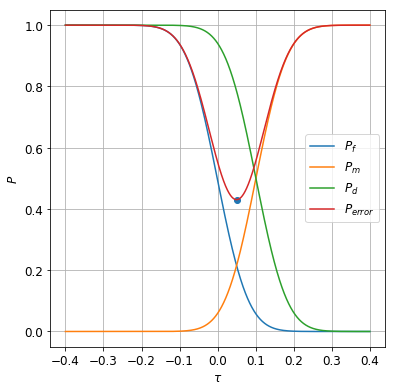

In [59]:
taus = np.linspace(-0.4, 0.4, 2001)
# note that scale represent the STD and not the variance.
pf = 1 - norm.cdf(taus, loc=mu_rho0, scale=np.sqrt(var_rho0))
pm = norm.cdf(taus, loc=mu_rho1, scale=np.sqrt(var_rho0))
pd = 1 - pm
pe = pf + pm

plt.plot(taus, pf, label="$P_f$")
plt.plot(taus, pm, label="$P_m$")
plt.plot(taus, pd, label="$P_d$")
plt.plot(taus, pe, label="$P_{error}$")

# bayessian hypothesis
ind = np.argmin(pe)

tau = taus[ind]

Pf = pf[ind]
Pm = pm[ind]
Pd = pd[ind]
Pe = pe[ind]

print('tau: {:.3f}'.format(tau))
print('Pf: {:.3f}'.format(Pf))
print('Pm: {:.3f}'.format(Pm))
print('Pd: {:.3f}'.format(Pd))
print('Pe: {:.3f}'.format(Pe))

plt.scatter(tau, Pe)
plt.xlabel(r"$\tau$")
plt.ylabel("$P$")
plt.legend()
plt.grid(True)
plt.show()

Using the Bayess hypotesis, the treshold $\tau$ can be found in the middle point (0.05) of the two distirbution (as the two hyptesis are equiprobable and have same variance). This is also shown in the figure above, as is in the middle point where the $P_{error}$ is minimal.

The resulting probabilities are:

 - $P_f : 0.218$
 - $P_m : 0.219$ 
 - $P_d : 0.781$

#### Exercise 1.2

In this exercise we were asked to evaluate the performance of the *Non-Blind* detector at different noise and watermark configurations.

In [60]:

def rhos0(host, var_noise, gamma, theta, k=300):
    rhos_0 = np.zeros(k)
    for i in range(0, k):
        # generation of noise
        z = np.random.normal(0, var_noise, host.shape)
        # genration of resulting image
        v = host + z    
  
        w = watermark(host.shape, theta)  
        rhos_0[i] = non_blind_detector(host, v, w)
    return rhos_0

def rhos1(host, var_noise, gamma, theta, k=300):
    rhos_1 = np.zeros(k)
    for i in range(0, k):
        # generation of noise
        z = np.random.normal(0, var_noise, host.shape)
        # watermark|
        w = watermark(host.shape, theta)
        # genration of resulting image
        v = host + w*gamma + z
        rhos_1[i] = non_blind_detector(host, v, w)
    return rhos_1

noise_vars = [50, 100]
thetas = [0.1, 0.3]
gammas = [1, 5]

mus_0 = []
mus_1 = []
vars_0 = []
vars_1 = []

labels = []

for var_noise in noise_vars:
    print("\nVariance(Noise): {}".format(var_noise))
    print("-------------------")
    for theta in thetas:
        print(" - Theta: {}".format(theta))
        for gamma in gammas:
            print("   - Gamma: {}".format(gamma))
            rhos_0 = rhos0(x, var_noise, gamma, theta, k)
            rhos_1 = rhos1(x, var_noise, gamma, theta, k)
            mu_rho0 = np.mean(rhos_0)
            mu_rho1 = np.mean(rhos_1)
            print("\t\tmean(rho|H0): {:.3f}".format(mu_rho0))
            print("\t\tmean(rho|H1): {:.3f}".format(mu_rho1))
            var_rho0 = np.var(rhos_0)
            var_rho1 = np.var(rhos_1)
            print("\t\tvariance(rho|H0): {:.3f}".format(var_rho0))
            print("\t\tvariance(rho|H1): {:.3f}".format(var_rho1))
            mus_0.append(mu_rho0)
            mus_1.append(mu_rho1)
            vars_0.append(var_rho0)
            vars_1.append(var_rho1)
            labels.append('{} - {} - {}'.format(var_noise, theta, gamma))


Variance(Noise): 50
-------------------
 - Theta: 0.1
   - Gamma: 1
		mean(rho|H0): -0.005
		mean(rho|H1): 0.095
		variance(rho|H0): 0.005
		variance(rho|H1): 0.004
   - Gamma: 5
		mean(rho|H0): 0.005
		mean(rho|H1): 0.499
		variance(rho|H0): 0.004
		variance(rho|H1): 0.004
 - Theta: 0.3
   - Gamma: 1
		mean(rho|H0): 0.001
		mean(rho|H1): 0.302
		variance(rho|H0): 0.012
		variance(rho|H1): 0.010
   - Gamma: 5
		mean(rho|H0): 0.014
		mean(rho|H1): 1.494
		variance(rho|H0): 0.013
		variance(rho|H1): 0.011

Variance(Noise): 100
-------------------
 - Theta: 0.1
   - Gamma: 1
		mean(rho|H0): 0.004
		mean(rho|H1): 0.104
		variance(rho|H0): 0.016
		variance(rho|H1): 0.015
   - Gamma: 5
		mean(rho|H0): -0.002
		mean(rho|H1): 0.485
		variance(rho|H0): 0.018
		variance(rho|H1): 0.016
 - Theta: 0.3
   - Gamma: 1
		mean(rho|H0): -0.008
		mean(rho|H1): 0.302
		variance(rho|H0): 0.043
		variance(rho|H1): 0.051
   - Gamma: 5
		mean(rho|H0): -0.030
		mean(rho|H1): 1.528
		variance(rho|H0): 0.045
		v

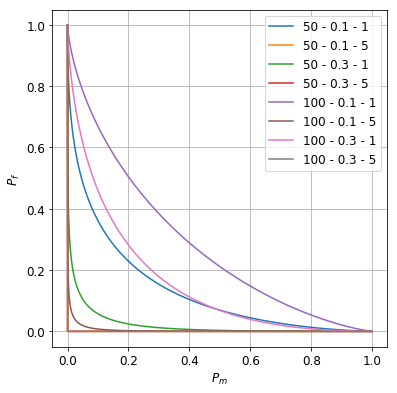

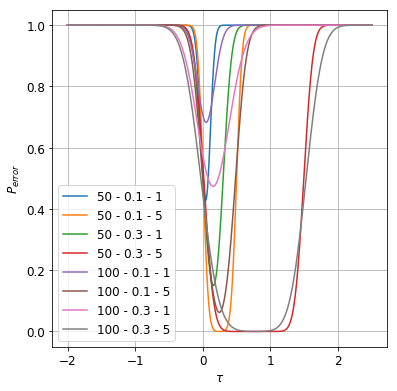

In [61]:
def RCO(mu0, mu1, var0, var1, label):
    t_min = mu0-np.sqrt(var0)*3
    t_max = mu1+np.sqrt(var1)*3
    num = int(round((t_max-t_min)*1000))
    ts = np.linspace(t_min, t_max, num+1)
    pf = 1 - norm.cdf(ts, loc=mu0, scale=np.sqrt(var0))
    pm = norm.cdf(ts, loc=mu1, scale=np.sqrt(var1))
    plt.figure(0)
    plt.plot(pm, pf, label=label)
    
    
def PERR(mu0, mu1, var0, var1, label):
    t_min = -2
    t_max = 2.5
    num = int(round((t_max-t_min)*1000))
    ts = np.linspace(t_min, t_max, num+1)
    pf = 1 - norm.cdf(ts, loc=mu0, scale=np.sqrt(var0))
    pm = norm.cdf(ts, loc=mu1, scale=np.sqrt(var1))
    pe = pf+pm
    plt.figure(1)
    plt.plot(ts, pe, label=label)
    
for i in range(0, len(vars_0)):
    RCO(mus_0[i], mus_1[i], vars_0[i], vars_1[i], labels[i])
    PERR(mus_0[i], mus_1[i], vars_0[i], vars_1[i], labels[i])
    
plt.figure(0)
plt.xlabel("$P_m$")
plt.ylabel("$P_f$")
plt.legend()
plt.grid(True)
plt.figure(1)
plt.xlabel(r"$\tau$")
plt.ylabel("$P_{error}$")
plt.legend()
plt.grid(True)


mu_non_blind = mus_1
sigma_non_blind = (np.array(vars_0)+np.array(vars_1))/2

plt.show()

In conclusion the parameters control respectivly:

 - $\theta_N$: variate proportionally $\mu_{\rho|H_1}$ and $\sigma_\rho^2$
 - $\gamma$: variate quadratically $\mu_{\rho|H_1}$
 - $\sigma^2_{noise}$: variate quadratically $\sigma_\rho^2$
 
This is visualized in the following plots:


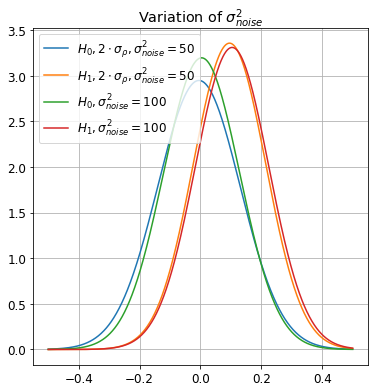

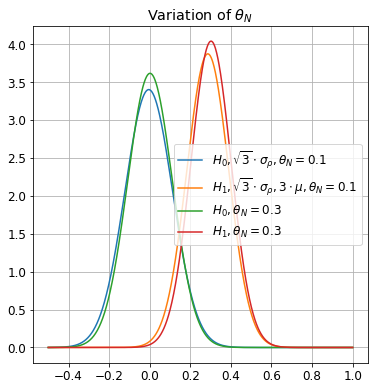

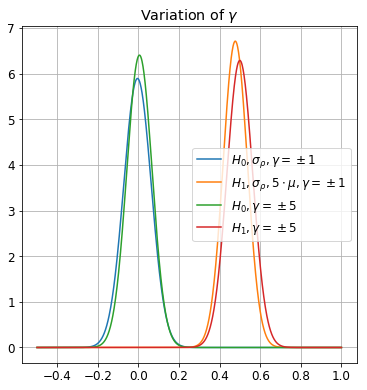

In [62]:
ts = np.linspace(-0.5,0.5,1001)

std_0 = np.sqrt(vars_0)
std_1 = np.sqrt(vars_1)

h0 = norm.pdf(ts,mus_0[0], 2*std_0[0])
h1= norm.pdf(ts,mus_1[0], 2*std_1[0])

plt.plot(ts, h0, label=r"$H_0, 2\cdot\sigma_\rho, \sigma_{noise}^2=50$")
plt.plot(ts, h1, label=r"$H_1, 2\cdot\sigma_\rho, \sigma_{noise}^2=50$")

h0 = norm.pdf(ts,mus_0[4], std_0[4])
h1= norm.pdf(ts,mus_1[4], std_1[4])

plt.plot(ts, h0, label="$H_0, \sigma_{noise}^2=100$")
plt.plot(ts, h1, label="$H_1, \sigma_{noise}^2=100$")
plt.legend()
plt.title("Variation of $\sigma^2_{noise}$")
plt.grid(True)

plt.figure()

ts = np.linspace(-0.5,1.0,1001)


h0 = norm.pdf(ts,mus_0[0], np.sqrt(3)*std_0[0])
h1= norm.pdf(ts,3*mus_1[0], np.sqrt(3)*std_1[0])

plt.plot(ts, h0, label=r"$H_0, \sqrt{3}\cdot\sigma_\rho, \theta_N=0.1$")
plt.plot(ts, h1, label=r"$H_1, \sqrt{3}\cdot\sigma_\rho, 3\cdot\mu, \theta_N=0.1$")

h0 = norm.pdf(ts,mus_0[2], std_0[2])
h1 = norm.pdf(ts,mus_1[2], std_1[2])

plt.plot(ts, h0, label=r"$H_0, \theta_N=0.3$")
plt.plot(ts, h1, label=r"$H_1, \theta_N=0.3$")
plt.legend()
plt.title(r"Variation of $\theta_{N}$")
plt.grid(True)

plt.figure()

ts = np.linspace(-0.5,1,1001)

h0 = norm.pdf(ts,mus_0[0], std_0[0])
h1= norm.pdf(ts,5*mus_1[0], std_1[0])

plt.plot(ts, h0, label=r"$H_0, \sigma_\rho, \gamma=\pm1$")
plt.plot(ts, h1, label=r"$H_1, \sigma_\rho, 5\cdot\mu, \gamma=\pm1$")

h0 = norm.pdf(ts,mus_0[1], std_0[1])
h1 = norm.pdf(ts,mus_1[1], std_1[1])

plt.plot(ts, h0, label="$H_0, \gamma=\pm5$")
plt.plot(ts, h1, label="$H_1, \gamma=\pm5$")
plt.legend()
plt.title("Variation of $\gamma$")
plt.grid(True)
plt.show()

## Blind watermark detection

#### Exercise 2.1
In this exercise we will evaluate the performances of a blind watermark detector using the same configuration than in the previous exercise.

The main difference (a very important one) is the fact that the detector doesn't have access to the original image but instead have only the watermarked noised one. To be able to extract the watermark, the host image is extimated using a low pass filter (a median filter in my case).



In [63]:

def rhos0(host, var_noise, gamma, theta, k=300):
    rhos_0 = np.zeros(k)
    for i in range(0, k):
        w = watermark(host.shape, theta)
        # generation of noise
        z = np.random.normal(0, var_noise, host.shape)
        # genration of resulting image
        v = host + z
        rhos_0[i] = blind_detector(v, w)
    return rhos_0

def rhos1(host, var_noise, gamma, theta, k=300):
    rhos_1 = np.zeros(k)
    for i in range(0, k):
        # watermark|
        w = watermark(host.shape, theta)
        # generation of noise
        z = np.random.normal(0, var_noise, host.shape)
        # genration of resulting image
        v = host + w*gamma + z
        rhos_1[i] = blind_detector(v, w)
    return rhos_1


noise_vars = [50, 100]
thetas = [0.1, 0.3]
gammas = [1, 5]

mus_0 = []
mus_1 = []
vars_0 = []
vars_1 = []

labels = []

for var_noise in noise_vars:
    print("\nVariance(Noise): {}".format(var_noise))
    print("-------------------")
    for theta in thetas:
        print(" - Theta: {}".format(theta))
        for gamma in gammas:
            print("   - Gamma: {}".format(gamma))
            rhos_0 = rhos0(x, var_noise, gamma, theta, k)
            rhos_1 = rhos1(x, var_noise, gamma, theta, k)
            mu_rho0 = np.mean(rhos_0)
            mu_rho1 = np.mean(rhos_1)
            print("\t\tmean(rho|H0): {:.3f}".format(mu_rho0))
            print("\t\tmean(rho|H1): {:.3f}".format(mu_rho1))
            var_rho0 = np.var(rhos_0)
            var_rho1 = np.var(rhos_1)
            print("\t\tvariance(rho|H0): {:.3f}".format(var_rho0))
            print("\t\tvariance(rho|H1): {:.3f}".format(var_rho1))
            mus_0.append(mu_rho0)
            mus_1.append(mu_rho1)
            vars_0.append(var_rho0)
            vars_1.append(var_rho1)
            labels.append('{} - {} - {}'.format(var_noise, theta, gamma))


Variance(Noise): 50
-------------------
 - Theta: 0.1
   - Gamma: 1
		mean(rho|H0): -0.002
		mean(rho|H1): 0.087
		variance(rho|H0): 0.004
		variance(rho|H1): 0.004
   - Gamma: 5
		mean(rho|H0): -0.008
		mean(rho|H1): 0.439
		variance(rho|H0): 0.004
		variance(rho|H1): 0.004
 - Theta: 0.3
   - Gamma: 1
		mean(rho|H0): -0.005
		mean(rho|H1): 0.270
		variance(rho|H0): 0.011
		variance(rho|H1): 0.011
   - Gamma: 5
		mean(rho|H0): -0.001
		mean(rho|H1): 1.317
		variance(rho|H0): 0.011
		variance(rho|H1): 0.012

Variance(Noise): 100
-------------------
 - Theta: 0.1
   - Gamma: 1
		mean(rho|H0): -0.011
		mean(rho|H1): 0.082
		variance(rho|H0): 0.013
		variance(rho|H1): 0.014
   - Gamma: 5
		mean(rho|H0): -0.015
		mean(rho|H1): 0.448
		variance(rho|H0): 0.016
		variance(rho|H1): 0.012
 - Theta: 0.3
   - Gamma: 1
		mean(rho|H0): -0.012
		mean(rho|H1): 0.250
		variance(rho|H0): 0.046
		variance(rho|H1): 0.039
   - Gamma: 5
		mean(rho|H0): -0.010
		mean(rho|H1): 1.335
		variance(rho|H0): 0.049

#### Exercise 2.2 

In this last exercise we will plot first the *ROC* of the *Blind* detector and evaluate the performance differences with the *Non-Blind* one.

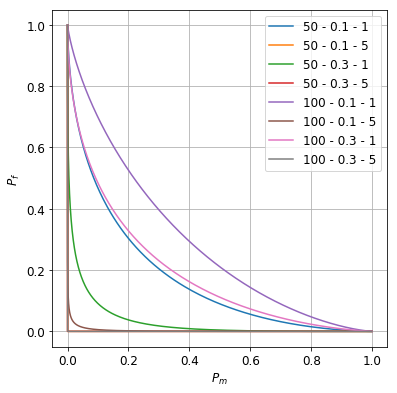

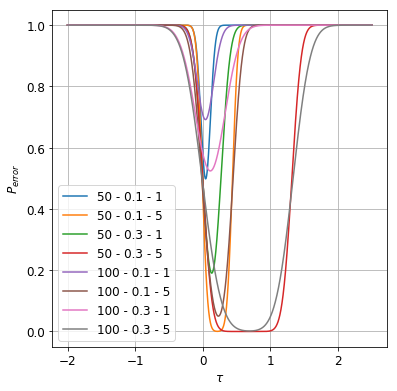

In [64]:
def RCO(mu0, mu1, var0, var1, label):
    t_min = mu0-np.sqrt(var0)*3
    t_max = mu1+np.sqrt(var1)*3
    num = int(round((t_max-t_min)*1000))
    ts = np.linspace(t_min, t_max, num+1)
    pf = 1 - norm.cdf(ts, loc=mu0, scale=np.sqrt(var0))
    pm = norm.cdf(ts, loc=mu1, scale=np.sqrt(var1))
    plt.figure(0)
    plt.plot(pm, pf, label=label)
    
    
def PERR(mu0, mu1, var0, var1, label):
    t_min = -2
    t_max = 2.5
    num = int(round((t_max-t_min)*1000))
    ts = np.linspace(t_min, t_max, num+1)
    pf = 1 - norm.cdf(ts, loc=mu0, scale=np.sqrt(var0))
    pm = norm.cdf(ts, loc=mu1, scale=np.sqrt(var1))
    pe = pf+pm
    plt.figure(1)
    plt.plot(ts, pe, label=label)
    
for i in range(0, len(vars_0)):
    RCO(mus_0[i], mus_1[i], vars_0[i], vars_1[i], labels[i])
    PERR(mus_0[i], mus_1[i], vars_0[i], vars_1[i], labels[i])
    
plt.figure(0)
plt.xlabel("$P_m$")
plt.ylabel("$P_f$")
plt.legend()
plt.grid(True)
plt.figure(1)
plt.xlabel(r"$\tau$")
plt.ylabel("$P_{error}$")
plt.legend()
plt.grid(True)

mu_blind = mus_1
sigma_blind = (np.array(vars_0)+np.array(vars_1))/2


plt.show()

As it's possible to see the *ROC* and the $P_{error}$ plots are both very similar to the *Non-Blind* ones. The $\gamma$,$\theta_N$ and $\sigma^2_{noise}$ has the same impact of before, however the fact that the original image is unkown has a small impact on the $\mu_{\rho|H_1}$, in average it is 10% smaller, and so close to $\mu_{\rho|H_0}$, increasing the overall probability of error.

Overall this small loss in performance doesn't impact to much in the detection of the watermark and with smarter filtering it could be possible to decrease the difference in performance between the two systems.

In [65]:
mu_blind = np.array(mu_blind)
mu_non_blind = np.array(mu_non_blind)
mu_diff = np.mean((mu_blind-mu_non_blind)/mu_non_blind)
mu_var = np.var((mu_blind-mu_non_blind)/mu_non_blind)
sigma_diff = np.mean((sigma_blind-sigma_non_blind)/sigma_non_blind)
sigma_var = np.var((sigma_blind-sigma_non_blind)/sigma_non_blind)
print("Difference of mean between detectors: {:.1f}%".format(100*mu_diff))
print("Variance: {:0.3f}".format(100*mu_var))
print("Difference of sigma between detectors: {:.1f}%".format(100*sigma_diff))
print("Variance: {:0.3f}".format(100*sigma_var))

Difference of mean between detectors: -12.7%
Variance: 0.173
Difference of sigma between detectors: -2.5%
Variance: 0.705
